# 2.11 - Image analysis & batch processing

### Learning goals for today
1. Learn how to create functions for common analysis tasks
2. Understand how to batch process data for repetitive analysis tasks

---
### How to use this notebook during class
- Follow along as we go
- Use your **Cards** to indicate where you're at:
    - A **🟩Green card** means you are caught up with Max and **ready to help your classmates**
    - A **🟥Red card** means you are stuck and need help
- <span style='color:red;'>EXERCISE</span> — work on this problem by yourself, or try with a partner if you get stuck
---


First let's import some libraries we will use today. Remember if you don't have a library installed you can pip install it with:

%pip install *package_name*

In [ ]:
%pip install scikit-image

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os 
import seaborn as sns
import skimage
from skimage.io import imread

In [2]:
data_directory = '/Users/sanjidaahmed/Downloads'
filepath = os.path.join(data_directory, 'xy_8bit__mitocheck_incenp_t1.tif')


assert os.path.isfile(filepath)

### <span style='color:red;'>EXERCISE - continuted</span>: Write a cell quantification function  (20 min)
I'm giving you the skeleton of a function definition to take an image as an input and return lists of the mean intensity and area of each detected cell.

Take the relevant lines of code above and modify / arrange them into the body of the function to achieve what you want. Be sure to: check your variable names, only take the bits of code that you need to compute the intensity and area, and test your function afterwards

Hint: start with **pseduocode**


In [28]:
from skimage.filters import threshold_li
from skimage.measure import label

def measure_cells(input_image, show_segmentation = False):
    """ 
        measure_cells(input_image)
            Using automatic thresholding to identify and quantify cell properties from fluor images
        
        args
            input_image: 2 dimensional ndarray
        returns
            intensity - list
            area - list
    """
    input_image = skimage.util.img_as_ubyte(input_image)

    
    # TODO: pick up here and write real code
    
    # compute the threshold

    thresh = threshold_li(input_image)

    # make a binary mask
    mask = input_image > thresh

    # identify the labels / components, exclude the background
    label_image = label(mask)  #label_image is ndarray with lable integers 
    labels = np.unique(label_image)[:1]
    

    # Compute the number of cells (should be the number of labels)
    num_cells = len(labels)
    
     


    # Find the area of each label's mask
    # Compute the mean intensity of each cell's masked area
    areas = []
    intensities = []
    for lab in labels:
        area = np.sum(label_image == lab)
        intensity = np.mean(input_image[label_image ==lab])
    
    labels = np.unique(label_image)
    for lab in labels:
        area = np.sum(label_image == lab)
        intensity = np.mean(input_image[label_image ==lab])
        
        areas.append(area)
        intensities.append(intensity)

    print(f'Found {num_cells} cells')

    if show_segmentation:
        fh, ax = plt.subplots(1,3, figsize=(12,4))
        ax[0].imshow(input_image, cmap='gray')
        ax[1].imshow(mask, cmap='gray')
        ax[2].imshow(label_image, cmap='tab20')    
        
    

    return areas, intensities

### Test your function

In [29]:
filepath = os.path.join(data_directory, 'xy_8bit__mitocheck_incenp_t1.tif')
img_cells = imread(filepath)
area, intensity = measure_cells(input_image=img_cells)
                                           
print(area)
print(intensity)

Found 1 cells
[np.int64(89558), np.int64(660), np.int64(607), np.int64(914), np.int64(768), np.int64(702), np.int64(696), np.int64(735)]
[np.float64(19.029455771678688), np.float64(40.39090909090909), np.float64(43.44481054365733), np.float64(46.26148796498906), np.float64(29.2109375), np.float64(29.93019943019943), np.float64(47.372126436781606), np.float64(44.69387755102041)]


## Batch processing

Often we write code to repeat some analyis steps on many datafiles. This is called **batch processing**.

Let's use a for-loop, and the function we just defined, to analyze many image files in a row.

We could hard-code in a list of the datafiles we want, or we could use **pattern matching** to identify files in a directory of interest. The Python library for this is built in and it's called **glob**. We can use wildcards like * to match a filename pattern.

In [35]:
import glob
batch_data_dir = '/Users/sanjidaahmed/Downloads/vgg_cells'
filepaths = glob.glob(os.path.join(batch_data_dir, '*.png'))

print(f'Found {len(filepaths)} image files')
print(filepaths[0])

Found 20 image files
/Users/sanjidaahmed/Downloads/vgg_cells/015cell.png


Found 1 cells
Found 1 cells
Found 1 cells
Found 1 cells
Found 1 cells
Found 1 cells
Found 1 cells
Found 1 cells
Found 1 cells
Found 1 cells
Found 1 cells
Found 1 cells
Found 1 cells
Found 1 cells
Found 1 cells
Found 1 cells
Found 1 cells
Found 1 cells
Found 1 cells
Found 1 cells


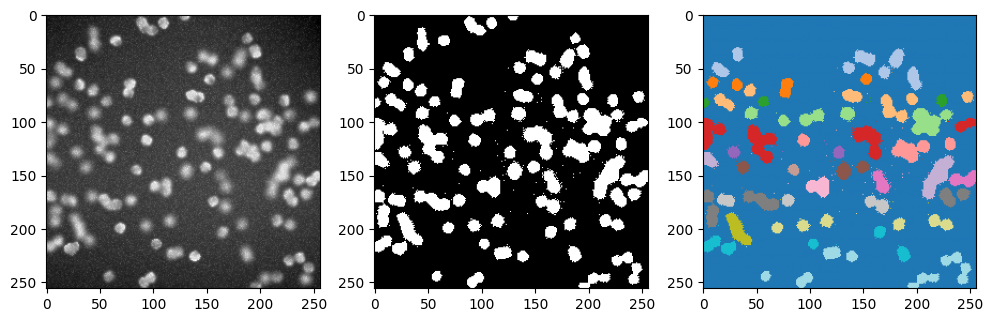

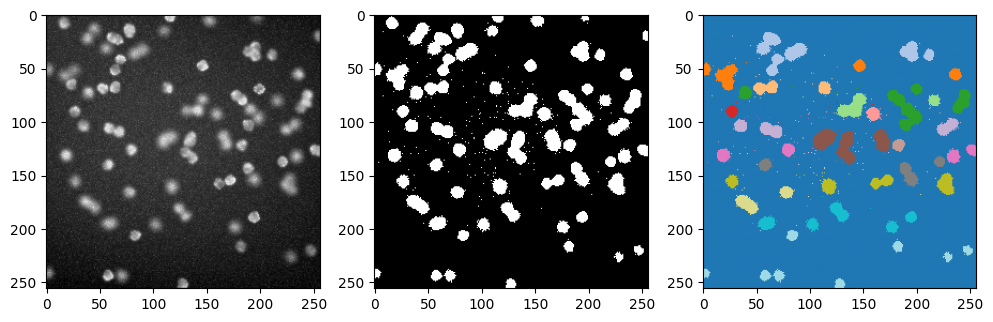

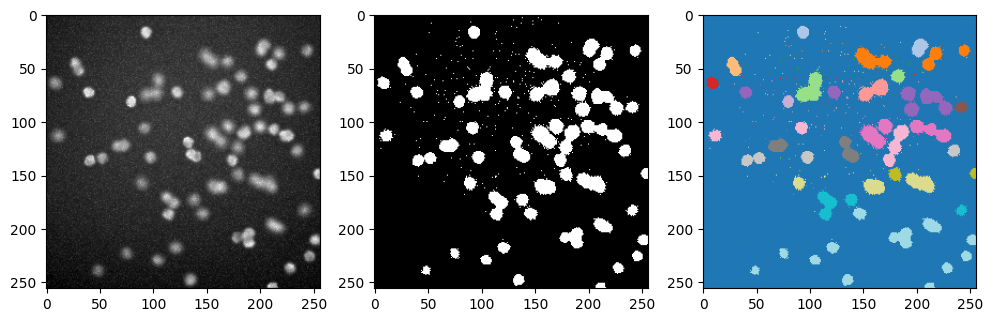

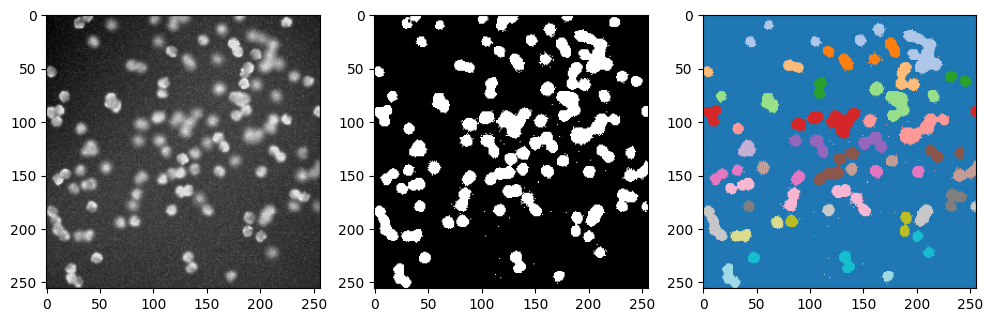

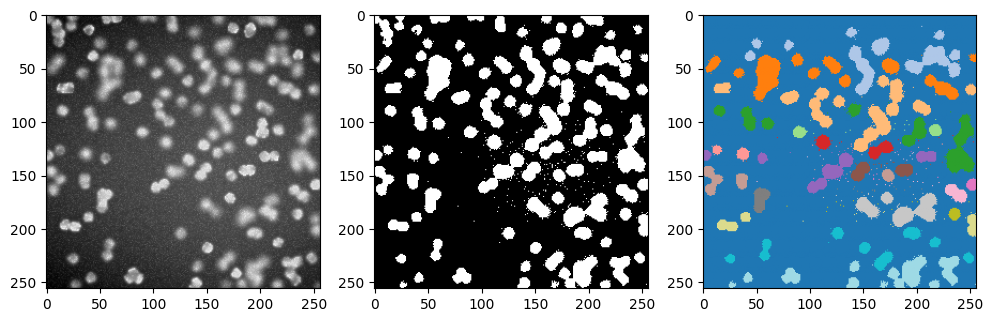

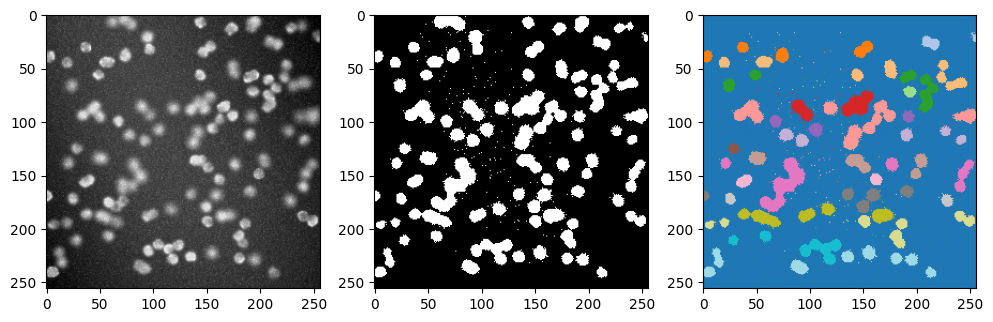

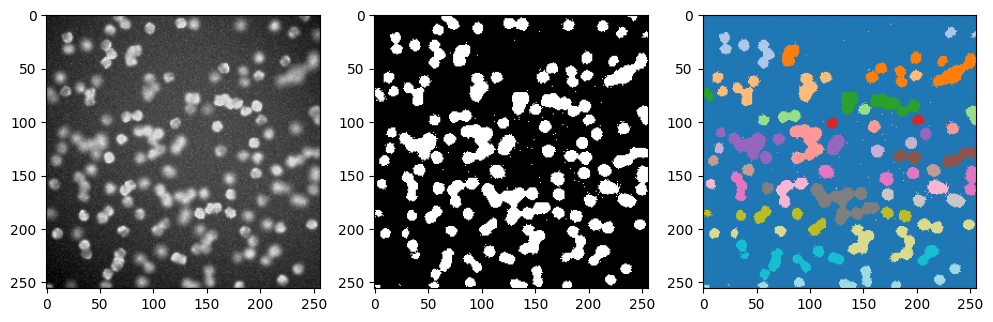

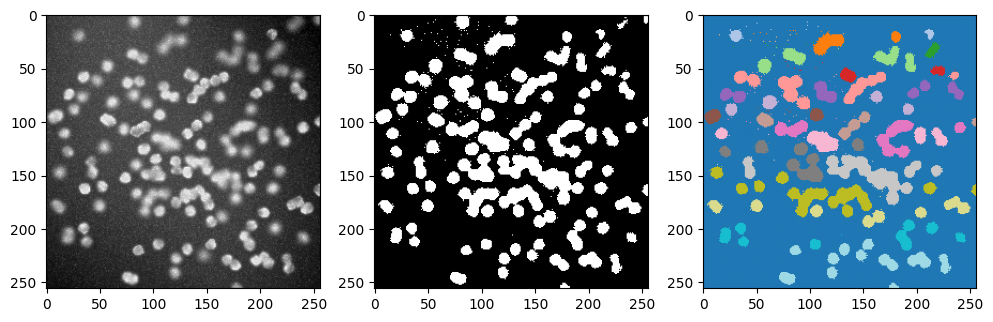

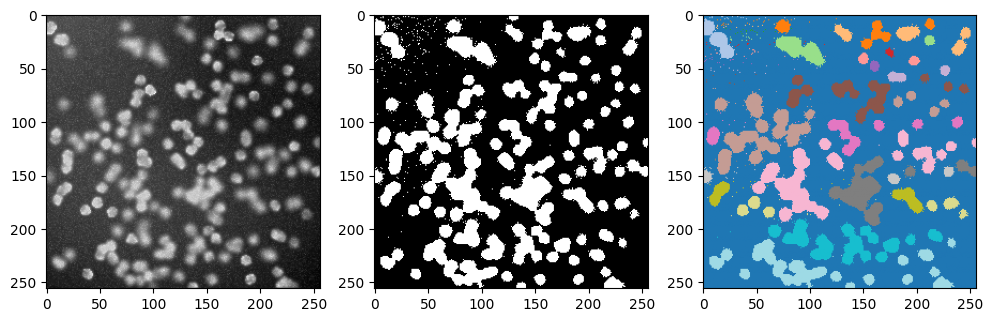

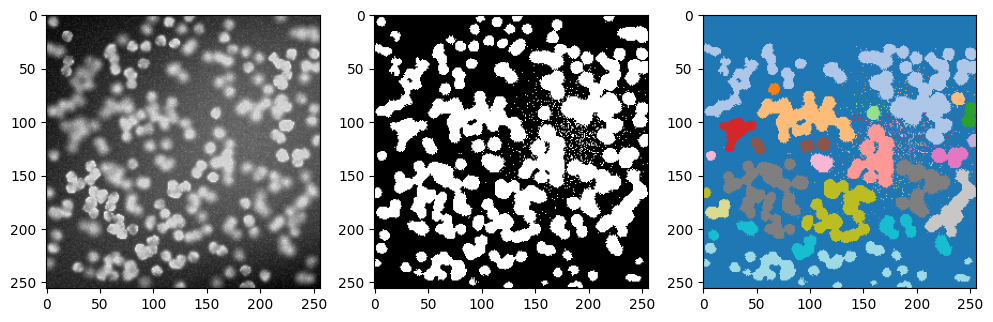

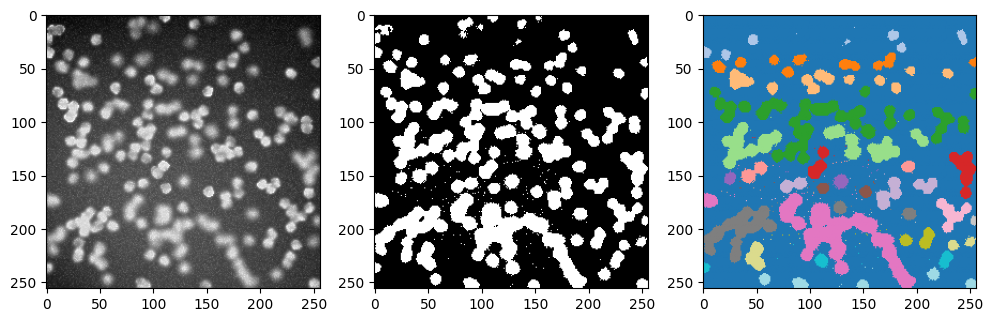

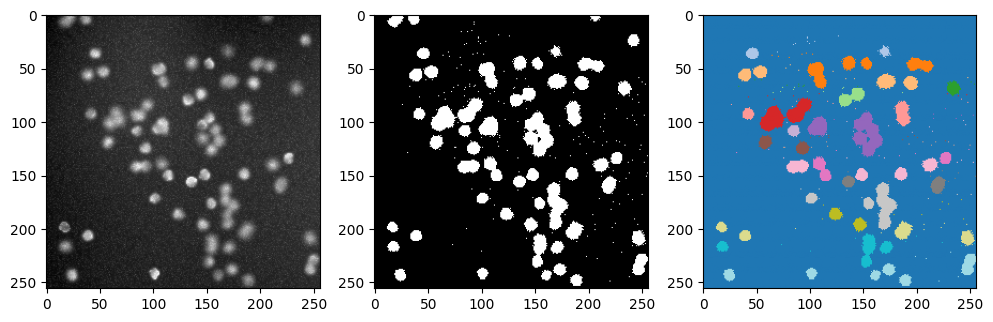

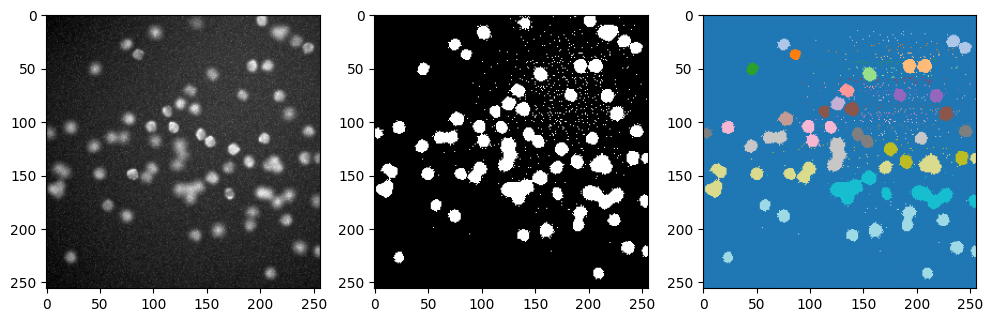

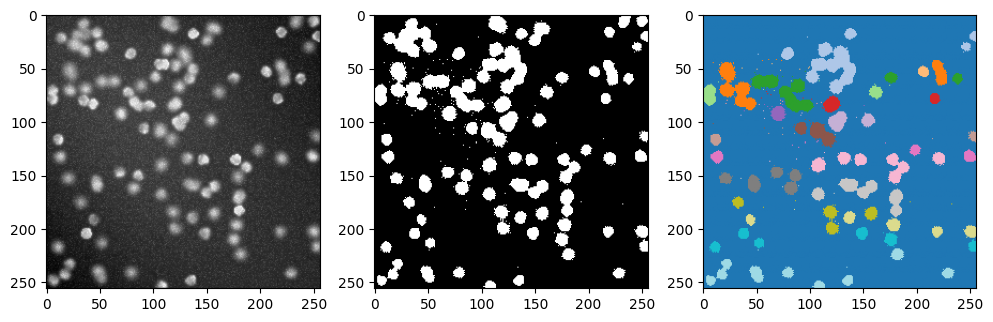

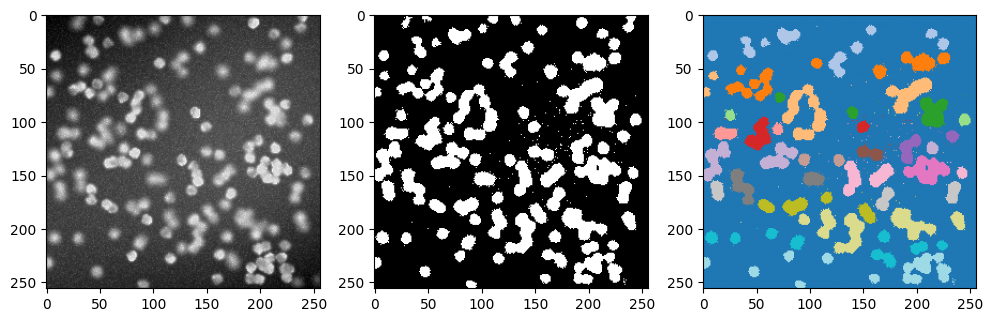

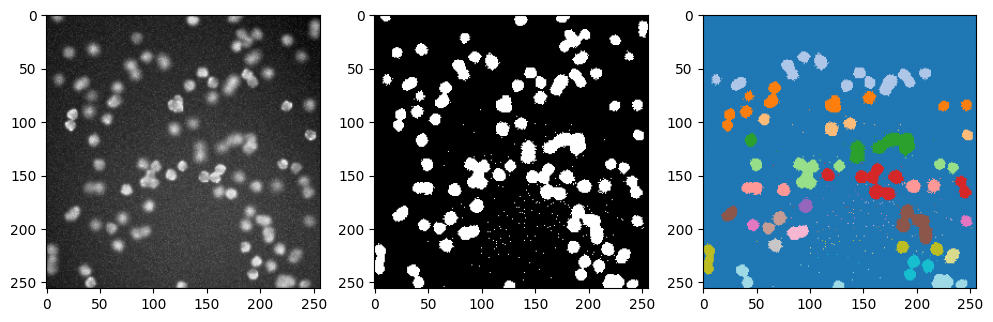

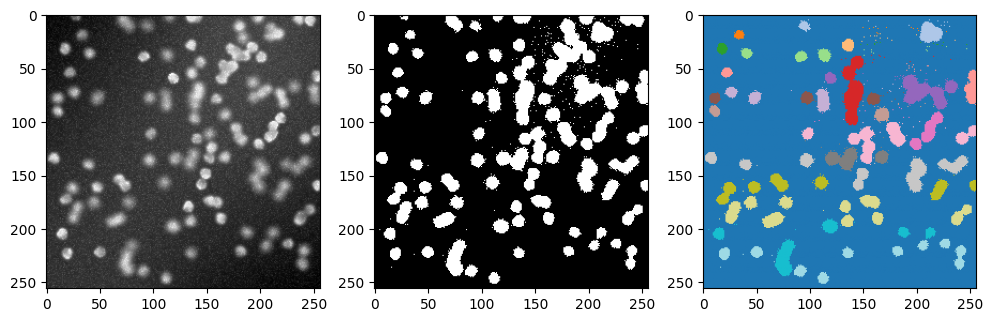

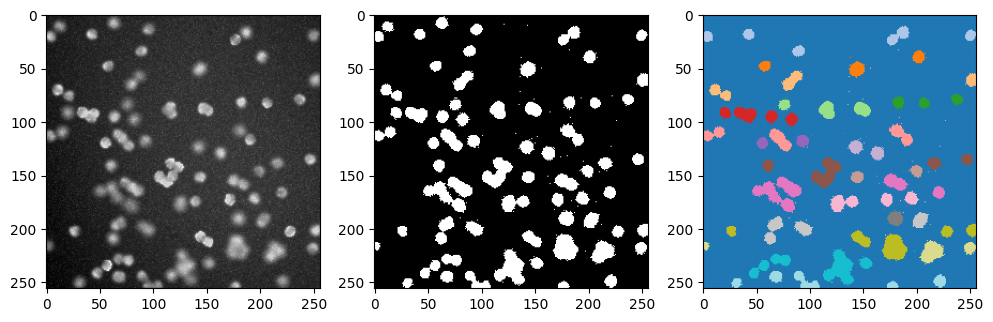

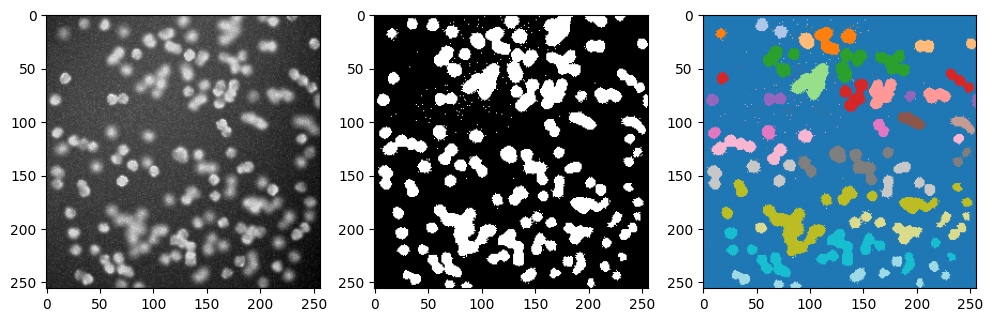

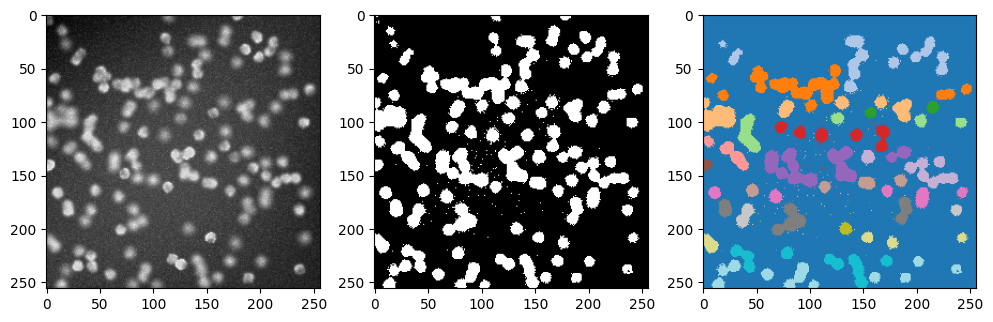

In [42]:
areas = []
intensities = []
n_cells = []
for filepath in filepaths:
    img_cells = imread(filepath, as_gray=True)
    area, intensity = measure_cells(input_image=img_cells,
                                      show_segmentation=True)
    
    intensities.append(intensity)
    areas.append(area)
    n_cells.append(len(area))


# Making our function more robust
These new images are harder for a few reasons:
1. There is non-uniform background illumination, which can cause thresholding failures
2. There is speckly noise, causing the algorithm to detect a ton of false positives
3. There are cells right up against the edge of the image, which would give us the wrong impression about cell sizes
4. Some cells touch and are counted as single components/cells

We're going to ignore #4 today. Fixing this is challenging and requires morphological operations or ways of identifying objects that aren't based only on intensity thresholding.

Let's fix problems 1 - 3 by re-writing our function to:
1. Use filtering to remove noise in the image
2. Remove the background
3. Remove labels of components at the edge of the image

### Collecting results across images
Once we get our function working with an acceptable level of accuracy, we will want to collect results across each image. 